<a href="https://colab.research.google.com/github/mingd00/Face-Recognition/blob/main/Notebooks/EfficientNet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EfficientNet 모델을 활용한 데이터 학습



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/face_recognition/'

### 라이브러리 호출

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import model_from_json
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
import cv2
import time

### 데이터 로드 및 준비


In [5]:
data = pd.read_csv(path + "data/face_emotion.csv")
data.head()

,emotion,pixels,Usage
0,0,195 184 176 178 179 182 184 181 177 171 164 17...,Training
1,0,87 85 80 75 74 76 76 75 73 73 74 76 80 82 86 8...,Training
2,0,154 153 205 179 180 174 158 99 123 135 172 203...,Training
3,0,208 219 226 213 211 178 86 95 100 103 104 104 ...,Training
4,0,61 56 50 46 43 39 36 33 31 30 29 28 26 24 23 2...,Training


In [6]:
len(data)

60000

- 용량이 너무 커서 클래스별로 나눠서 처리

emotion
0    10000
1    10000
2    10000
3    10000
5    10000
4    10000
Name: count, dtype: int64


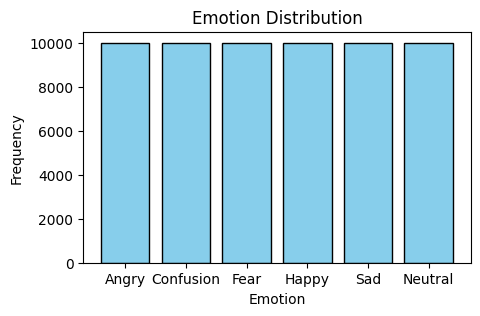

In [7]:
# 감정 매핑
emotion_mapping = {0:'Angry', 1:'Confusion', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Neutral'}

# 고유값 및 빈도 확인
emotion_counts = data["emotion"].value_counts()
print(emotion_counts)

# 히스토그램 그리기
plt.figure(figsize=(5, 3))
plt.bar(emotion_mapping.values(), [emotion_counts.get(i, 0) for i in emotion_mapping.keys()], color='skyblue', edgecolor='black')

# 그래프 제목 및 레이블 설정
plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Frequency")

plt.show()

In [8]:
# usage 컬럼 제거
data = data.drop(columns=["Usage"])

# emotion별로 데이터 분리 및 새로운 데이터프레임 할당
df0 = data[data["emotion"] == 0].reset_index(drop=True)
df0 = df0.iloc[:10000]
df1 = data[data["emotion"] == 1].reset_index(drop=True)
df1 = df1.iloc[:10000]
df2 = data[data["emotion"] == 2].reset_index(drop=True)
df2 = df2.iloc[:10000]
df3 = data[data["emotion"] == 3].reset_index(drop=True)
df3 = df3.iloc[:10000]
df4 = data[data["emotion"] == 4].reset_index(drop=True)
df4 = df4.iloc[:10000]
df5 = data[data["emotion"] == 5].reset_index(drop=True)
df5 = df5.iloc[:10000]

# 결과 출력 (각 데이터프레임의 샘플 개수 확인)
print(f"df0: {len(df0)} rows")
print(f"df1: {len(df1)} rows")
print(f"df2: {len(df2)} rows")
print(f"df3: {len(df3)} rows")
print(f"df4: {len(df4)} rows")
print(f"df5: {len(df5)} rows")

df0: 10000 rows
df1: 10000 rows
df2: 10000 rows
df3: 10000 rows
df4: 10000 rows
df5: 10000 rows


In [9]:
def preprocess(data):
    # 픽셀 데이터를 효율적으로 처리
    def process_pixels(pixel_str, index):
        try:
            pixels = np.array(pixel_str.split(), dtype='float32') / 255.0
            if len(pixels) != 2304:  # 48x48 크기가 아닌 경우 처리
                print(f"Invalid pixel length at index {index}: {len(pixels)}")
                return None
            return pixels
        except ValueError:
            print(f"Invalid pixel data at index {index}: {pixel_str}")
            return None

    # 픽셀 데이터 처리
    valid_pixels = []
    valid_labels = []
    for i, (pixel_str, label) in enumerate(zip(data['pixels'], data['emotion'])):
        processed = process_pixels(pixel_str, i)
        if processed is not None:
            valid_pixels.append(processed)
            valid_labels.append(label)

    # NumPy 배열로 변환
    pixels = np.array(valid_pixels).reshape(-1, 48, 48, 1)  # 48x48 그레이스케일 이미지
    pixels = np.repeat(pixels, 3, axis=-1)  # 3채널로 확장
    labels = np.array(valid_labels)  # 원-핫 인코딩을 하지 않고 정수 레이블로 유지

    # 학습/검증 데이터 분리
    X_train, X_val, y_train, y_val = train_test_split(pixels, labels, test_size=0.2, random_state=42, shuffle=True)
    return X_train, X_val, y_train, y_val

In [10]:
X_train0, X_val0, y_train0, y_val0 = preprocess(df0)
print(f"Shapes-> X_train0: {X_train0.shape}, X_val0: {X_val0.shape}, y_train0: {y_train0.shape}, y_val0: {y_val0.shape}")

Shapes-> X_train0: (8000, 48, 48, 3), X_val0: (2000, 48, 48, 3), y_train0: (8000,), y_val0: (2000,)


In [11]:
X_train1, X_val1, y_train1, y_val1 = preprocess(df1)
print(f"Shapes-> X_train1: {X_train1.shape}, X_val1: {X_val1.shape}, y_train1: {y_train1.shape}, y_val1: {y_val1.shape}")

Shapes-> X_train1: (8000, 48, 48, 3), X_val1: (2000, 48, 48, 3), y_train1: (8000,), y_val1: (2000,)


In [12]:
X_train2, X_val2, y_train2, y_val2 = preprocess(df2)
print(f"Shapes-> X_train2: {X_train2.shape}, X_val2: {X_val2.shape}, y_train2: {y_train2.shape}, y_val2: {y_val2.shape}")

Shapes-> X_train2: (8000, 48, 48, 3), X_val2: (2000, 48, 48, 3), y_train2: (8000,), y_val2: (2000,)


In [13]:
X_train3, X_val3, y_train3, y_val3 = preprocess(df3)
print(f"Shapes-> X_train3: {X_train3.shape}, X_val3: {X_val3.shape}, y_train3: {y_train3.shape}, y_val3: {y_val3.shape}")

Shapes-> X_train3: (8000, 48, 48, 3), X_val3: (2000, 48, 48, 3), y_train3: (8000,), y_val3: (2000,)


In [14]:
X_train4, X_val4, y_train4, y_val4 = preprocess(df4)
print(f"Shapes-> X_train4: {X_train4.shape}, X_val4: {X_val4.shape}, y_train4: {y_train4.shape}, y_val4: {y_val4.shape}")

Shapes-> X_train4: (8000, 48, 48, 3), X_val4: (2000, 48, 48, 3), y_train4: (8000,), y_val4: (2000,)


In [15]:
X_train5, X_val5, y_train5, y_val5 = preprocess(df5)
print(f"Shapes-> X_train5: {X_train5.shape}, X_val5: {X_val5.shape}, y_train5: {y_train5.shape}, y_val5: {y_val5.shape}")

Shapes-> X_train5: (8000, 48, 48, 3), X_val5: (2000, 48, 48, 3), y_train5: (8000,), y_val5: (2000,)


In [16]:
# 병합
X_train = np.concatenate([X_train0, X_train1, X_train2, X_train3, X_train4, X_train5], axis=0)
del X_train0, X_train1, X_train2, X_train3, X_train4, X_train5  # X_train 관련 변수 삭제

X_val = np.concatenate([X_val0, X_val1, X_val2, X_val3, X_val4, X_val5], axis=0)
del X_val0, X_val1, X_val2, X_val3, X_val4, X_val5  # X_val 관련 변수 삭제

y_train = np.concatenate([y_train0, y_train1, y_train2, y_train3, y_train4, y_train5], axis=0)
del y_train0, y_train1, y_train2, y_train3, y_train4, y_train5  # y_train 관련 변수 삭제

y_val = np.concatenate([y_val0, y_val1, y_val2, y_val3, y_val4, y_val5], axis=0)
del y_val0, y_val1, y_val2, y_val3, y_val4, y_val5  # y_val 관련 변수 삭제

# 합친 데이터의 형태 확인
print(f"Shapes-> X_train: {X_train.shape}, X_val: {X_val.shape}, y_train: {y_train.shape}, y_val: {y_val.shape}")

Shapes-> X_train: (48000, 48, 48, 3), X_val: (12000, 48, 48, 3), y_train: (48000,), y_val: (12000,)


In [17]:
y_train

array([0, 0, 0, ..., 5, 5, 5])

### 얼굴 인식 모델

In [18]:
# 얼굴 인식 함수
def detect_face(frame):
    cascPath = path + 'model/haarcascade_frontalface_default.xml'
    faceCascade = cv2.CascadeClassifier(cascPath)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    detected_faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=6,
        minSize=(48, 48),  # 얼굴 크기
        flags=cv2.CASCADE_SCALE_IMAGE
    )

    if len(detected_faces) > 0:
        return gray, detected_faces[0]  # 첫 번째 얼굴만 처리
    else:
        return gray, None  # 얼굴이 탐지되지 않으면 None 반환

In [19]:
# 얼굴 특징 추출 함수
def extract_face_features(gray, detected_face, offset_coefficients=(0.075, 0.05), shape_x=48, shape_y=48):
    if detected_face is None:
        return None  # 얼굴이 없으면 None 반환

    x, y, w, h = detected_face

    horizontal_offset = int(np.floor(offset_coefficients[0] * w))
    vertical_offset = int(np.floor(offset_coefficients[1] * h))

    # 추출할 얼굴 영역 설정
    extracted_face = gray[
        y + vertical_offset : y + h,
        x + horizontal_offset : x - horizontal_offset + w
    ]

    # 추출된 얼굴 이미지를 줌 조정 (설정된 크기로 스케일 변경)
    new_extracted_face = zoom(
        extracted_face,
        (shape_x / extracted_face.shape[0], shape_y / extracted_face.shape[1])  # 목표 크기로 조정
    )

    # 데이터를 float32 형식으로 변환
    new_extracted_face = new_extracted_face.astype(np.float32)

    # 이미지를 정규화 (최대값으로 나누어 0~1 사이 값으로 변환)
    new_extracted_face /= float(new_extracted_face.max())

    # 정규화된 얼굴 이미지를 반환
    return new_extracted_face

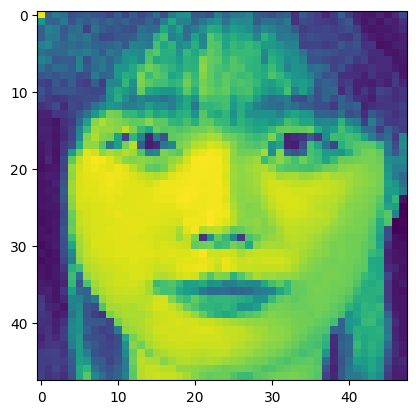

In [20]:
img = cv2.imread(path + "test_data/img.jpg")
gray, detected_face = detect_face(img)

if detected_face is not None:
    extracted_face = extract_face_features(gray, detected_face)
    plt.imshow(extracted_face)
else:
    print("No face detected in the image.")

### 표정 분류 모델

- 첫 번째 학습
- 전이 학습(feature extraction(transfer learning)): 사전 학습된 가중치는 고정하여 특징을 추출하고 새로운 출력 레이어만 학습

In [25]:
def transfer_learning():
    # EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
    base_model = EfficientNetB0(weights='imagenet',
                                include_top=False, # 최상위 layer 제외
                                input_shape=(48, 48, 3))

    # Feature extraction layers를 고정
    base_model.trainable = False

    # 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
    input_shape = (48, 48, 3)
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)  # EfficientNet feature extractor
    x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x) # 드롭아웃
    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs, outputs)

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
    )


    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # 정수 레이블
                  metrics=['accuracy'])

    return model, datagen

In [26]:
model, datagen = transfer_learning()

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history = model.fit(train_datagen, epochs=10, validation_data=val_datagen)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 74s 38ms/step - accuracy: 0.1702 - loss: 1.9173 - val_accuracy: 0.1666 - val_loss: 1.7975
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1673 - loss: 1.8583 - val_accuracy: 0.1693 - val_loss: 1.7941
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.1729 - loss: 1.8427 - val_accuracy: 0.1677 - val_loss: 1.7910
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1749 - loss: 1.8372 - val_accuracy: 0.1666 - val_loss: 1.7953
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1702 - loss: 1.8324 - val_accuracy: 0.1669 - val_loss: 1.7933
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1736 - loss: 1.8265 - val_accuracy: 0.1666 - val_loss: 1.7953
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1716 - loss: 1.8222 - val_accuracy: 0.1667 - val_loss: 1.7970
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.1722 -

In [ ]:
def transfer_learning2():
    # EfficientNetB0 로드 (사전 학습된 ImageNet 가중치 사용)
    base_model = EfficientNetB0(weights='imagenet',
                                include_top=False, # 최상위 layer 제외
                                input_shape=(48, 48, 3))

    # Feature extraction layers를 고정
    base_model.trainable = False

    # 모델 수정 (FER 데이터셋에 맞게 출력 레이어 조정)
    input_shape = (48, 48, 3)
    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)  # EfficientNet feature extractor
    x = GlobalAveragePooling2D()(x)  # 공간 차원을 평균화하여 벡터로 변환
    x = Dropout(0.5)(x) # 드롭아웃
    outputs = Dense(6, activation='softmax')(x)

    model = Model(inputs, outputs)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',  # 정수 레이블
                  metrics=['accuracy'])

    return model

In [ ]:
model = transfer_learning2()

# 모델 학습
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.1631 - loss: 1.8562 - val_accuracy: 0.1667 - val_loss: 1.8217
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1622 - loss: 1.8392 - val_accuracy: 0.1667 - val_loss: 1.8130
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1668 - loss: 1.8348 - val_accuracy: 0.1667 - val_loss: 1.8343
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1602 - loss: 1.8338 - val_accuracy: 0.1667 - val_loss: 1.8062
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1626 - loss: 1.8331 - val_accuracy: 0.1667 - val_loss: 1.8019
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1658 - loss: 1.8310 - val_accuracy: 0.1667 - val_loss: 1.8062
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.1699 - loss: 1.8307 - val_accuracy: 0.1667 - val_loss: 1.8087
Epoch 8/10
1500/1500 ━━━━━━━━━━

In [32]:
def plot_history(history):
    # 1. 손실 함수 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['loss'], 'r', linewidth=2.0)
    plt.plot(history.history['val_loss'], 'b', linewidth=2.0)
    plt.legend(['Training loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')

    # 2. 정확도 그래프
    plt.figure(figsize=(5, 3))
    plt.plot(history.history['accuracy'], 'r', linewidth=2.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')

    plt.show()

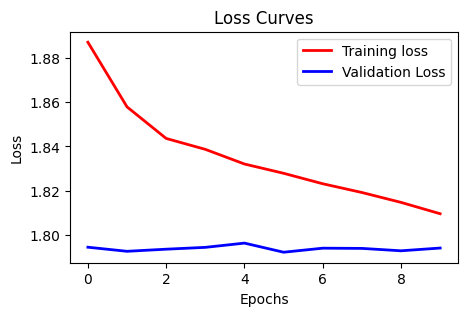

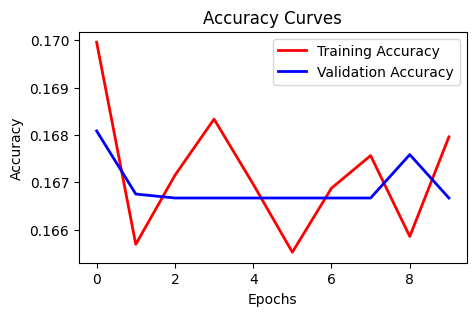

In [ ]:
plot_history(history)

- 두 번째 학습: 가중치 조정하고 추가 학습

In [ ]:
def fine_tune_model(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [ ]:
# 모델 Fine-Tuning 학습
model_ft, datagen = fine_tune_model(model)

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history_ft = model_ft.fit(train_datagen, epochs=50, validation_data=val_datagen)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 167s 61ms/step - accuracy: 0.2314 - loss: 1.7712 - val_accuracy: 0.2918 - val_loss: 1.7222
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 85s 57ms/step - accuracy: 0.3057 - loss: 1.6511 - val_accuracy: 0.2984 - val_loss: 1.6594
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 135s 52ms/step - accuracy: 0.3321 - loss: 1.5898 - val_accuracy: 0.3685 - val_loss: 1.5315
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.3562 - loss: 1.5604 - val_accuracy: 0.3540 - val_loss: 1.5543
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.3689 - loss: 1.5414 - val_accuracy: 0.3778 - val_loss: 1.5849
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 50ms/step - accuracy: 0.3809 - loss: 1.5187 - val_accuracy: 0.3768 - val_loss: 1.5227
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 84s 52ms/step - accuracy: 0.3818 - loss: 1.5125 - val_accuracy: 0.3833 - val_loss: 1.4883
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 51ms/step - accuracy: 0.3817

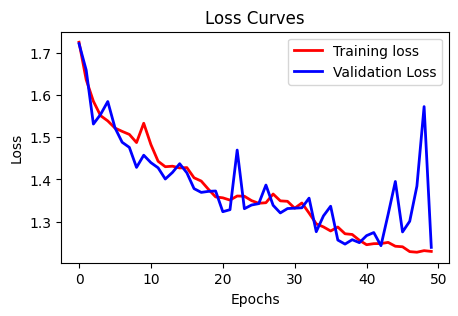

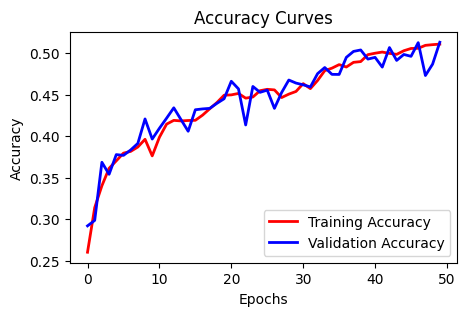

In [ ]:
plot_history(history_ft)

In [ ]:
def fine_tune_model2(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [ ]:
# 모델 Fine-Tuning 학습
model_ft2, datagen = fine_tune_model2(model)

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history_ft = model_ft2.fit(train_datagen, epochs=50, validation_data=val_datagen)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 133s 39ms/step - accuracy: 0.1977 - loss: 1.7919 - val_accuracy: 0.2740 - val_loss: 1.7098
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.2725 - loss: 1.7060 - val_accuracy: 0.3105 - val_loss: 1.6490
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 54s 36ms/step - accuracy: 0.3085 - loss: 1.6538 - val_accuracy: 0.3310 - val_loss: 1.6079
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 34ms/step - accuracy: 0.3267 - loss: 1.6180 - val_accuracy: 0.3447 - val_loss: 1.5828
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.3450 - loss: 1.5842 - val_accuracy: 0.3593 - val_loss: 1.5503
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.3546 - loss: 1.5619 - val_accuracy: 0.3701 - val_loss: 1.5212
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.3647 - loss: 1.5381 - val_accuracy: 0.3861 - val_loss: 1.5011
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 52s 35ms/step - accuracy: 0.3797 

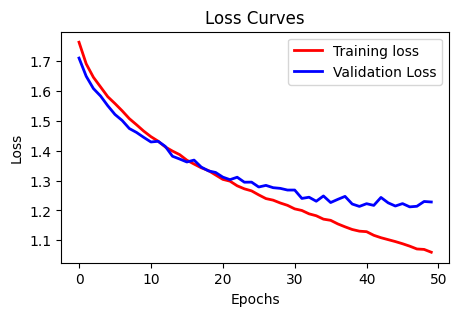

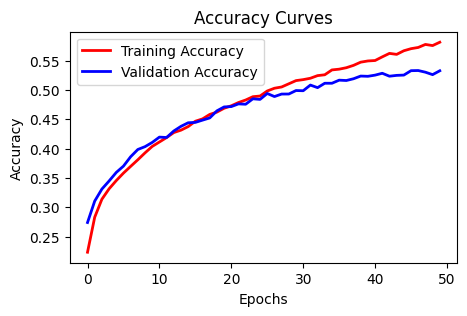

In [ ]:
plot_history(history_ft)

- 전이 학습 모델 Fully Connected Layer 제거 및 약한 데이터 증강 적용 후 재학습

In [ ]:
# 모델 Fine-Tuning 학습
model_ft2, datagen = fine_tune_model2(model)

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history_ft = model_ft2.fit(train_datagen, epochs=50, validation_data=val_datagen)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 190s 65ms/step - accuracy: 0.2109 - loss: 1.8979 - val_accuracy: 0.2693 - val_loss: 1.7223
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 93s 60ms/step - accuracy: 0.2696 - loss: 1.7318 - val_accuracy: 0.3169 - val_loss: 1.6485
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 147s 63ms/step - accuracy: 0.2988 - loss: 1.6677 - val_accuracy: 0.3327 - val_loss: 1.6030
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 97s 65ms/step - accuracy: 0.3303 - loss: 1.6162 - val_accuracy: 0.3556 - val_loss: 1.5622
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 136s 61ms/step - accuracy: 0.3428 - loss: 1.5786 - val_accuracy: 0.3725 - val_loss: 1.5303
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 149s 65ms/step - accuracy: 0.3643 - loss: 1.5438 - val_accuracy: 0.3826 - val_loss: 1.4987
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 140s 64ms/step - accuracy: 0.3833 - loss: 1.5076 - val_accuracy: 0.3976 - val_loss: 1.4791
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 90s 60ms/step - accuracy: 0.3946 - loss:

In [ ]:
def fine_tune_model3(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )


    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [ ]:
# 모델 Fine-Tuning 학습
model_ft3, datagen = fine_tune_model3(model)

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history_ft3 = model_ft3.fit(train_datagen, epochs=50, validation_data=val_datagen)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 160s 57ms/step - accuracy: 0.2183 - loss: 1.8902 - val_accuracy: 0.2897 - val_loss: 1.6912
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - accuracy: 0.2941 - loss: 1.6945 - val_accuracy: 0.3402 - val_loss: 1.5999
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 88s 59ms/step - accuracy: 0.3276 - loss: 1.6199 - val_accuracy: 0.3587 - val_loss: 1.5815
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 76s 50ms/step - accuracy: 0.3484 - loss: 1.5713 - val_accuracy: 0.3738 - val_loss: 1.5278
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - accuracy: 0.3707 - loss: 1.5246 - val_accuracy: 0.3944 - val_loss: 1.4855
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.3968 - loss: 1.4769 - val_accuracy: 0.3927 - val_loss: 1.4756
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 78s 52ms/step - accuracy: 0.4170 - loss: 1.4412 - val_accuracy: 0.4277 - val_loss: 1.4177
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 77s 51ms/step - accuracy: 0.4322 - loss: 1.4

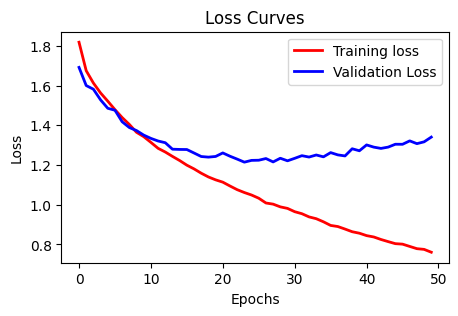

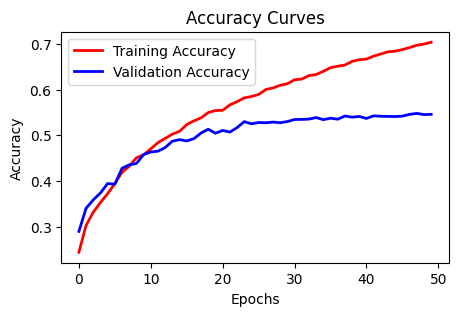

In [ ]:
plot_history(history_ft3)

In [ ]:
def fine_tune_model4(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.001,  # 초기 학습률
        decay_steps=1500,             # 1500 스텝마다
        decay_rate=0.9               # 학습률이 90%로 줄어듦
    )

    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [ ]:
# 모델 Fine-Tuning 학습
model_ft4, datagen = fine_tune_model4(model)

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)
val_datagen = datagen.flow(X_val, y_val, batch_size=32)

history_ft4 = model_ft4.fit(train_datagen, epochs=50, validation_data=val_datagen)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 150s 57ms/step - accuracy: 0.3455 - loss: 1.6049 - val_accuracy: 0.3826 - val_loss: 1.5077
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 81s 54ms/step - accuracy: 0.3987 - loss: 1.4878 - val_accuracy: 0.4157 - val_loss: 1.4225
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 71s 47ms/step - accuracy: 0.4352 - loss: 1.4014 - val_accuracy: 0.4304 - val_loss: 1.3921
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 95s 56ms/step - accuracy: 0.4534 - loss: 1.3460 - val_accuracy: 0.4728 - val_loss: 1.3041
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 54ms/step - accuracy: 0.4843 - loss: 1.2903 - val_accuracy: 0.4903 - val_loss: 1.2978
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 75s 50ms/step - accuracy: 0.4974 - loss: 1.2576 - val_accuracy: 0.5064 - val_loss: 1.2439
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 78s 47ms/step - accuracy: 0.5143 - loss: 1.2193 - val_accuracy: 0.5176 - val_loss: 1.2042
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 82s 47ms/step - accuracy: 0.5257 - loss: 1.1

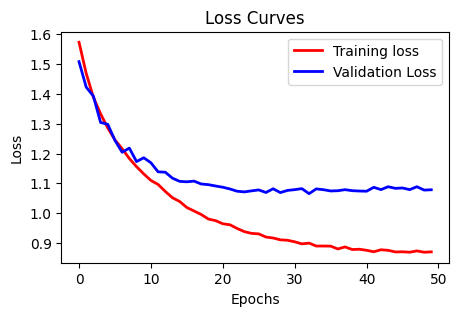

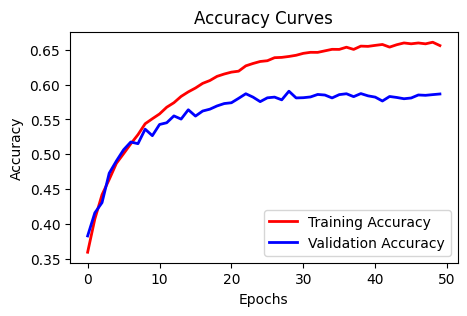

In [ ]:
plot_history(history_ft4)

In [ ]:
def fine_tune_model5(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
    )

    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.0005,  # 초기 학습률
        decay_steps=1500,             # 1500 스텝마다
        decay_rate=0.9               # 학습률이 90%로 줄어듦
    )

    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=lr_schedule),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [ ]:
# 모델 Fine-Tuning 학습
model_ft5, datagen= fine_tune_model5(model)

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)

history_ft5 = model_ft5.fit(train_datagen, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 115s 34ms/step - accuracy: 0.4907 - loss: 1.2790 - val_accuracy: 0.4840 - val_loss: 1.3041
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.5044 - loss: 1.2480 - val_accuracy: 0.4988 - val_loss: 1.2717
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 30ms/step - accuracy: 0.5206 - loss: 1.2006 - val_accuracy: 0.5207 - val_loss: 1.2028
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.5385 - loss: 1.1572 - val_accuracy: 0.5209 - val_loss: 1.2232
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.5541 - loss: 1.1217 - val_accuracy: 0.5340 - val_loss: 1.1939
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 45s 30ms/step - accuracy: 0.5696 - loss: 1.0837 - val_accuracy: 0.5398 - val_loss: 1.1792
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.5835 - loss: 1.0542 - val_accuracy: 0.5322 - val_loss: 1.1968
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 29ms/step - accuracy: 0.5939 

In [29]:
def fine_tune_model6(model):
    # 모든 레이어 가중치 조정 가능하게 설정
    for layer in model.layers:
        layer.trainable = True

    # 데이터 증강 설정
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
    )

    lr_schedule = ExponentialDecay(
        initial_learning_rate=0.0005,  # 초기 학습률
        decay_steps=1500,             # 1500 스텝마다
        decay_rate=0.9               # 학습률이 90%로 줄어듦
    )

    # 모델 재컴파일
    model.compile(optimizer=Adam(learning_rate=0.0005),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model, datagen

In [30]:
# 모델 Fine-Tuning 학습
model_ft6, datagen= fine_tune_model6(model)

# 콜백 설정
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

# 데이터 증강된 데이터 생성
train_datagen = datagen.flow(X_train, y_train, batch_size=32)

history_ft6 = model_ft6.fit(train_datagen, epochs=50, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1500/1500 ━━━━━━━━━━━━━━━━━━━━ 115s 37ms/step - accuracy: 0.5835 - loss: 1.0488 - val_accuracy: 0.4963 - val_loss: 1.3178
Epoch 2/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.5743 - loss: 1.0764 - val_accuracy: 0.5096 - val_loss: 1.2838
Epoch 3/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.5825 - loss: 1.0668 - val_accuracy: 0.5375 - val_loss: 1.2153
Epoch 4/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.5899 - loss: 1.0461 - val_accuracy: 0.5336 - val_loss: 1.2296
Epoch 5/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.5950 - loss: 1.0355 - val_accuracy: 0.5251 - val_loss: 1.2589
Epoch 6/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.6060 - loss: 1.0036 - val_accuracy: 0.5434 - val_loss: 1.2050
Epoch 7/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 50s 33ms/step - accuracy: 0.6158 - loss: 0.9843 - val_accuracy: 0.5521 - val_loss: 1.1741
Epoch 8/50
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.6252 - loss: 0.9

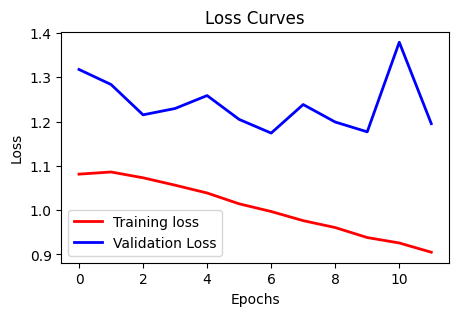

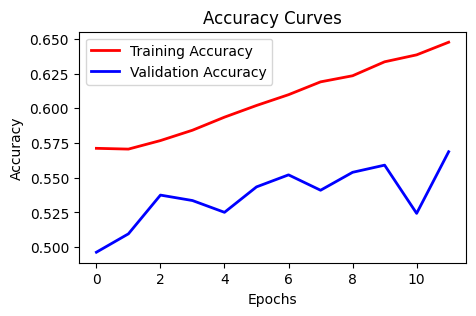

In [33]:
plot_history(history_ft6)

### 모델 저장 및 호출

In [ ]:
model_ft4.save('model.keras')

In [ ]:
new_model = load_model('model.keras')

### 예측

- 사진 예측

In [ ]:
def process_img(img_path, model):
  emotion_labels = ['화남', '당황', '불안', '행복', '슬픔', '중립']
  img = cv2.imread(img_path)
  gray, detected_face = detect_face(img)

  if detected_face is not None:
      extracted_face = extract_face_features(gray, detected_face)
      if extracted_face is not None:
          # 예시: 모델에 입력하기 전에 이미지를 3채널로 확장 (EfficientNet 입력 요구 사항)
          extracted_face = np.repeat(extracted_face, 3, axis=-1)  # 1채널을 3채널로 변환
          extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

          # 예측 (모델은 이미 로드되어 있다고 가정)
          res = new_model.predict(extracted_face)
          result_num = np.argmax(res)
          print(f"표정 예측: {emotion_labels[result_num]}")
      else:
          print("얼굴 추출에 실패했습니다.")
  else:
      print("얼굴을 찾을 수 없습니다.")

process_img(path + "test_data/img.jpg", new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
표정 예측: 슬픔


- 영상 예측(0.5초에 한번씩 캡쳐해서 이미지로 예측)

In [ ]:
def process_video(video_path, model):
    emotion_labels = ['Angry', 'Confusion', 'Fear', 'Happy', 'Sad', 'Neutral']

    # 영상 파일 열기
    video_capture = cv2.VideoCapture(video_path)

    # 영상의 FPS 확인
    fps = video_capture.get(cv2.CAP_PROP_FPS)  # 초당 프레임 수
    frame_interval = int(fps / 2)  # 0.5초 기준 프레임 간격 계산

    # 현재 시간
    frame_count = 0  # 프레임을 카운트하는 변수

    while True:
        # 영상에서 프레임 읽기
        ret, frame = video_capture.read()

        # 프레임이 제대로 읽어졌는지 확인
        if not ret:
            print("영상에서 프레임을 읽을 수 없습니다.")
            break

        # 지정한 간격마다 프레임 처리
        if frame_count % frame_interval == 0:
            # 얼굴 감지 및 특징 추출
            gray, detected_face = detect_face(frame)

            # 초 계산
            current_time_sec = frame_count / fps

            if detected_face is not None:
                # 얼굴 특징 추출
                extracted_face = extract_face_features(gray, detected_face)
                if extracted_face is not None:
                    # 1채널 이미지를 3채널로 확장
                    extracted_face = np.repeat(extracted_face, 3, axis=-1)
                    extracted_face = np.reshape(extracted_face, (1, 48, 48, 3))  # 모델 입력 형태로 변환

                    # 예측 (모델은 이미 로드되어 있다고 가정)
                    res = model.predict(extracted_face)
                    result_num = np.argmax(res)
                    print(f"[{current_time_sec:.2f}초] 표정 예측: {emotion_labels[result_num]}")

                else:
                    print("얼굴 추출에 실패했습니다.")
            else:
                print("얼굴을 찾을 수 없습니다.")

        # 프레임 카운트 증가
        frame_count += 1

    # 모든 작업 완료 후 캡처 리소스 해제
    video_capture.release()
    cv2.destroyAllWindows()


process_video(path + 'test_data/video.mp4', new_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
[0.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[1.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[1.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
[2.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[2.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[3.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[3.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[4.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[4.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[5.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
[5.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[6.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
[6.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[7.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[7.50초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[8.00초] 표정 예측: Sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22m